# Generative Adversarial Networks (GANs) and Their Variants

In this notebook, we will:

- Introduce the basic architecture of GANs, including the roles of the **Generator** and **Discriminator**
- Explain the training process and key challenges
- Implement a simple GAN on MNIST dataset.
- Implement a simple DCGAN (Deep Convolutional GAN) on CelebA dataset.
- Discuss common GAN variants such as Conditional GANs, CycleGANs, and others

## Introduction to GANs

Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow in 2014 [paper](https://arxiv.org/abs/1406.2661). The core idea is to have two neural networks—a **Generator** and a **Discriminator**—competing against each other:

- **Generator (G):** Takes in random noise (from a latent space) and attempts to generate realistic data (e.g., images).
- **Discriminator (D):** Receives both real data (from the training set) and fake data (produced by the generator) and tries to distinguish between the two.

During training, G improves at fooling D, while D gets better at detecting fakes. This adversarial process drives the generator to produce increasingly realistic outputs.

### Key Points

- **Adversarial Loss:** Both networks are trained with opposing objectives. The generator’s loss is designed to maximize the discriminator’s error, while the discriminator minimizes classification errors.
$$
\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)} \left[ \log D(x) \right] + \mathbb{E}_{z \sim p_{z}(z)} \left[ \log \big(1 - D(G(z))\big) \right]
$$

- **Training Challenges:** GANs are notoriously difficult to train due to issues such as mode collapse, non-convergence, and delicate balance between the two networks.

# Training a Simple GAN on MNIST

In the following we will import the Generator and Discriminator Networks from the [gan.py](./gan.py) file. and import the nessisarly packages.

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from gan import Discriminator, Generator
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm  # Update tqdm import for notebook integration

# Set manual seed for reproducibility
seed = 42
print("Random Seed: ", seed)
torch.manual_seed(seed)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Random Seed:  42
Device: cuda


## Data Preparation

For this demonstration, we will use the MNIST dataset. Later, we will train a DCGAN on CelebA to see how the model adapts to more complex images.

We will normalize the images to the range [-1, 1] (a common practice for GANs) and load the data using PyTorch’s `DataLoader`.

In [ ]:
# Configuration dictionary
config = {
    "batch_size": 64,
    "latent_dim": 100,  # size of the latent z vector
    "learning_rate": 0.0002,
    "epochs": 5,
}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
dataset = datasets.MNIST(root="../data", train=True,
                         download=True, transform=transform)

# Create the dataloader
dataloader = DataLoader(
    dataset, batch_size=config["batch_size"], shuffle=True, num_workers=0
)

## Defining the GAN Architecture

In the following we import the **Generator** and **Discriminator** networks and use [torchinfo](TODO: torch info link) to show the architecture of or Networks.

**Note** You need have `torchinfo` installed, you can do so via `pip install torchinfo`.


### Generator

The generator takes a latent vector (random noise) as input and produces an image. We use a series of transposed convolutions to upsample the latent space to the image dimensions.


In [ ]:
import torchinfo

generator = Generator(config["latent_dim"])

torchinfo.summary(generator,
                  input_size=(config["batch_size"], config["latent_dim"]),
                  col_names=["input_size", "output_size", "num_params"],
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Mult-Adds
Generator (Generator)                    [64, 100]                 [64, 1, 28, 28]           --                        --
├─Sequential (net)                       [64, 100]                 [64, 784]                 --                        --
│    └─Linear (0)                        [64, 100]                 [64, 128]                 12,928                    827,392
│    └─ReLU (1)                          [64, 128]                 [64, 128]                 --                        --
│    └─Linear (2)                        [64, 128]                 [64, 256]                 33,024                    2,113,536
│    └─BatchNorm1d (3)                   [64, 256]                 [64, 256]                 512                       32,768
│    └─ReLU (4)                          [64, 256]                 [64, 256]                 --                        --
│

### Discriminator

The discriminator is a convolutional network that takes an image as input and outputs a single scalar representing the probability that the input is real.

In [ ]:
discriminator = Discriminator()

torchinfo.summary(discriminator,
                  input_size=(config["batch_size"], 28, 28),
                  col_names=["input_size", "output_size", "num_params", "mult_adds"],
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Mult-Adds
Discriminator (Discriminator)            [64, 28, 28]              [64, 1]                   --                        --
├─Sequential (net)                       [64, 784]                 [64, 1]                   --                        --
│    └─Linear (0)                        [64, 784]                 [64, 512]                 401,920                   25,722,880
│    └─LeakyReLU (1)                     [64, 512]                 [64, 512]                 --                        --
│    └─Linear (2)                        [64, 512]                 [64, 256]                 131,328                   8,404,992
│    └─LeakyReLU (3)                     [64, 256]                 [64, 256]                 --                        --
│    └─Linear (4)                        [64, 256]                 [64, 1]                   257                       16,44

## Training the GAN

We now define the training loop. In each iteration:

1. **Discriminator Training:**
   - Use a batch of real images and label them as 1.
   - Generate a batch of fake images from noise and label them as 0.
2. **Generator Training:**
   - Generate a batch of fake images.
   - Compute the loss against a target label of 1 (i.e., tricking the discriminator).

For simplicity, we use the Binary Cross Entropy loss. You may explore other loss functions in advanced exercises.

### Breaking Down the Minimax Loss

- **Discriminator’s Role:**  
  The discriminator aims to correctly classify real and fake data:
  - For real data $ x $, it wants $ D(x) $ (the probability of being real) to be close to 1, maximizing $\log D(x)$.
  - For generated (fake) data $ G(z) $, it wants $ D(G(z)) $ to be close to 0, maximizing $\log\big(1 - D(G(z))\big)$.

- **Generator’s Role:**  
  The generator aims to "fool" the discriminator. Although its objective can be written as minimizing $\log\big(1 - D(G(z))\big)$, this often leads to vanishing gradients. Therefore, a common alternative is for the generator to maximize $\log D(G(z))$ (or equivalently, minimize $-\log D(G(z))$).

#### Connection to Binary Cross Entropy (BCE)

The Binary Cross Entropy loss for a single sample is defined as:

$$
\text{BCE}(p, y) = -\Big[ y \log(p) + (1 - y) \log\big(1 - p\big) \Big]
$$

where:
- $ p $ is the predicted probability (e.g., $ D(x) $).
- $ y $ is the true label (1 for real data, 0 for fake data).

##### Derivation for Real Data ($ y = 1 $)

Substitute $ y = 1 $ into the BCE formula:

$$
\text{BCE}(D(x), 1) = -\Big[ 1 \cdot \log(D(x)) + 0 \cdot \log\big(1-D(x)\big) \Big] = -\log\big(D(x)\big)
$$

This directly corresponds to the term $\log D(x)$ in the GAN minimax loss.

##### Derivation for Fake Data ($ y = 0 $)

Substitute $ y = 0 $:

$$
\text{BCE}(D(G(z)), 0) = -\Big[ 0 \cdot \log(D(G(z))) + 1 \cdot \log\big(1-D(G(z))\big) \Big] = -\log\big(1-D(G(z))\big)
$$

This matches the term $\log\big(1-D(G(z))\big)$ in the minimax loss.

#### Recap

- The **discriminator’s loss** can be seen as the sum of two BCE losses:
  $$
  L_D = -\log\big(D(x)\big) - \log\big(1-D(G(z))\big)
  $$
- The **generator’s loss** (using the non-saturating version) becomes:
  $$
  L_G = -\log\big(D(G(z))\big)
  $$

Starting Training Loop...


Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Batches for Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

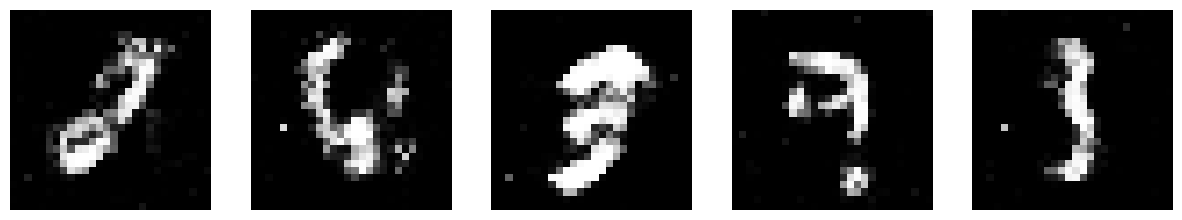

Processing Batches for Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

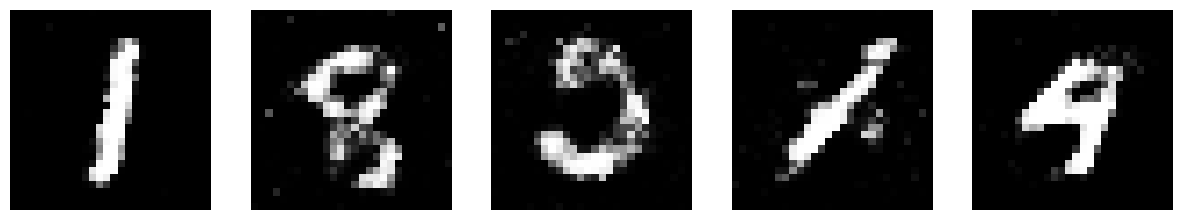

Processing Batches for Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

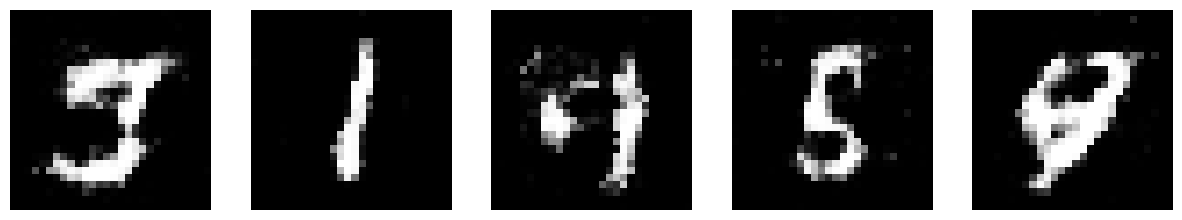

Processing Batches for Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

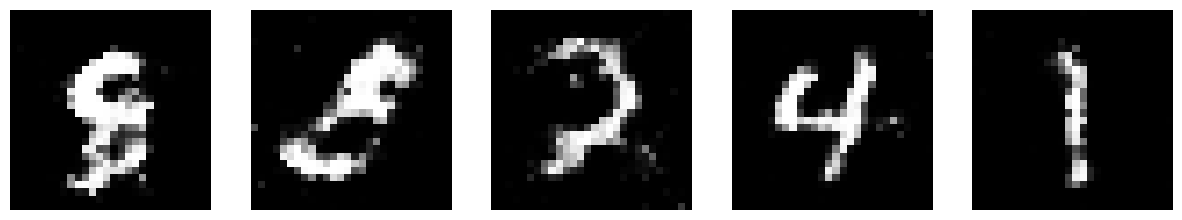

Processing Batches for Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

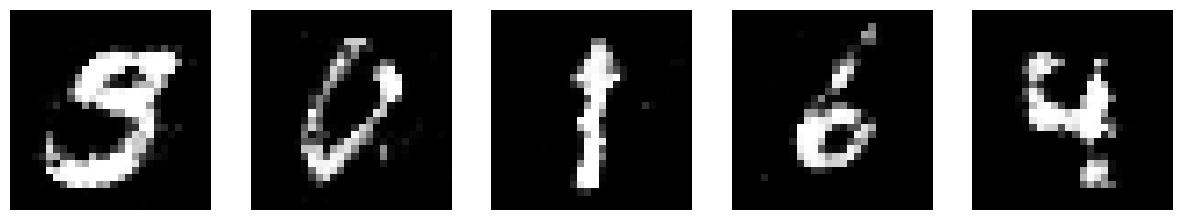

In [ ]:
# Setup optimizers for both G and D
optimizerG = optim.Adam(generator.parameters(), lr=config["learning_rate"])
optimizerD = optim.Adam(discriminator.parameters(), lr=config["learning_rate"])


print("Starting Training Loop...")
for epoch in tqdm(range(config["epochs"]), desc="Training Epochs", leave=False):
    for i, (imgs, _) in enumerate(tqdm(dataloader, desc=f"Processing Batches for Epoch {epoch+1}", leave=False)):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)

        # Define adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizerG.zero_grad()

        # Generate a batch of images
        z = torch.randn(batch_size, config["latent_dim"], device=device)
        fake_imgs = generator(z)

        # Loss: generator tries to fool the discriminator
        g_loss = F.binary_cross_entropy(discriminator(fake_imgs), valid)
        g_loss.backward()
        optimizerG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizerD.zero_grad()

        real_loss = F.binary_cross_entropy(discriminator(imgs), valid)
        fake_loss = F.binary_cross_entropy(discriminator(fake_imgs.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizerD.step()

    # Plot 5 generated images after each epoch to show the generator's training progress
    with torch.no_grad():
        noise = torch.randn(5, config["latent_dim"], device=device)
        fake_imgs = generator(noise).detach().cpu()

        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for idx, ax in enumerate(axes):
            ax.imshow(fake_imgs[idx].squeeze().numpy(), cmap='gray')
            ax.axis('off')
        plt.show()

# Deep Convolutional GANs (DCGANs)

While simple GAN architectures perform reasonably well on small grayscale images, they often struggle to effectively capture local and global structures due to the flattening of input images.

To address this limitation, we can utilize convolutional layers, which are particularly effective at preserving spatial hierarchies and capturing intricate image features. Incorporating convolutional layers significantly enhances the performance of GAN models, leading to improved quality in generated images.

In the following example, we import basic generator and discriminator network architectures from [dcgan/models.py](./dcgan/models.py)

In [1]:
import torch
from dcgan.models import Discriminator, Generator

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

inference_config = {
    "latent_dim": 100,
    "image_size": 64,     # output image size (64x64)
    "nc": 3,              # number of channels (3 for RGB)
    "ngf": 64,            # generator feature map size
    "ndf": 64,            # discriminator feature map size
}


Device: cuda


In [7]:
import inspect
from IPython.display import Code, display

generator_source = inspect.getsource(Generator)
display(Code(generator_source, language='python'))


class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        
        self.latent_dim = config["latent_dim"]
        self.ngf = config["ngf"]
        self.nc = config["nc"]

        # DCGAN generator architecture
        self.main = nn.Sequential(

            # Input: latent vector Z (batch_size, latent_dim, 1, 1)
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),

            # State: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),

            # State: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),

            # State: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),

            # State: (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (nc) x 64 x 64
        )
    
    def forward(self, input):
        return self.main(input)

In [14]:
import torchinfo

generator = Generator(inference_config)

torchinfo.summary(generator,
                  input_size=(16, inference_config["latent_dim"], 1, 1),
                  col_names=["input_size", "output_size"],
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape
Generator (Generator)                    [16, 100, 1, 1]           [16, 3, 64, 64]
├─Sequential (main)                      [16, 100, 1, 1]           [16, 3, 64, 64]
│    └─ConvTranspose2d (0)               [16, 100, 1, 1]           [16, 512, 4, 4]
│    └─BatchNorm2d (1)                   [16, 512, 4, 4]           [16, 512, 4, 4]
│    └─ReLU (2)                          [16, 512, 4, 4]           [16, 512, 4, 4]
│    └─ConvTranspose2d (3)               [16, 512, 4, 4]           [16, 256, 8, 8]
│    └─BatchNorm2d (4)                   [16, 256, 8, 8]           [16, 256, 8, 8]
│    └─ReLU (5)                          [16, 256, 8, 8]           [16, 256, 8, 8]
│    └─ConvTranspose2d (6)               [16, 256, 8, 8]           [16, 128, 16, 16]
│    └─BatchNorm2d (7)                   [16, 128, 16, 16]         [16, 128, 16, 16]
│    └─ReLU (8)                          [16, 128, 16, 16]         [16, 128, 16, 16]
│

In [8]:
discriminator_source = inspect.getsource(Discriminator)
display(Code(discriminator_source, language='python'))

class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()

        self.ndf = config["ndf"]
        self.nc = config["nc"]

        # DCGAN discriminator architecture
        self.main = nn.Sequential(

            # Input: (nc) x 64 x 64
            nn.Conv2d(self.nc, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State: (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [15]:
discriminator = Discriminator(inference_config)

torchinfo.summary(discriminator,
                  input_size=(16, 3, inference_config["image_size"], inference_config["image_size"]),
                  col_names=["input_size", "output_size"],
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape
Discriminator (Discriminator)            [16, 3, 64, 64]           [16]
├─Sequential (main)                      [16, 3, 64, 64]           [16, 1, 1, 1]
│    └─Conv2d (0)                        [16, 3, 64, 64]           [16, 64, 32, 32]
│    └─LeakyReLU (1)                     [16, 64, 32, 32]          [16, 64, 32, 32]
│    └─Conv2d (2)                        [16, 64, 32, 32]          [16, 128, 16, 16]
│    └─BatchNorm2d (3)                   [16, 128, 16, 16]         [16, 128, 16, 16]
│    └─LeakyReLU (4)                     [16, 128, 16, 16]         [16, 128, 16, 16]
│    └─Conv2d (5)                        [16, 128, 16, 16]         [16, 256, 8, 8]
│    └─BatchNorm2d (6)                   [16, 256, 8, 8]           [16, 256, 8, 8]
│    └─LeakyReLU (7)                     [16, 256, 8, 8]           [16, 256, 8, 8]
│    └─Conv2d (8)                        [16, 256, 8, 8]           [16, 512, 4, 4]
│    └─Batch

Since training a GAN model on the CelebA dataset can be time-consuming, we can download the pretrained model from the HuggingFace (repository)[]

## 6. Exploring GAN Variants

Once you are comfortable with the basic GAN, you may explore the following variants:

- **Conditional GANs (cGANs):** Generate images conditioned on labels. For example, generate MNIST digits conditioned on the digit label.
- **DCGAN:** The architecture we used here is inspired by DCGAN. For higher resolution images, deeper networks may be needed.
- **CycleGAN:** Used for image-to-image translation without paired examples (e.g., converting horses to zebras).
- **InfoGAN:** Designed to learn interpretable and disentangled representations by maximizing mutual information.

### Hands-On Exercise

1. Modify the generator and discriminator to accept label information (i.e., implement a conditional GAN on MNIST).
2. Experiment with different loss functions or network architectures to see how the output quality changes.
3. Try using a different dataset (such as CelebA) and adjust the network layers accordingly.

Each variant introduces new challenges and techniques that are valuable in professional AI work.

## 7. Conclusion and Next Steps

In this notebook, you learned:

- The basic concept of GANs and their adversarial training process
– How to implement a simple DCGAN on MNIST using PyTorch
- An overview of popular GAN variants and ideas for further exploration

### Recommended Tools and Platforms

- **PyTorch / TensorFlow:** Frameworks for deep learning
- **Weights & Biases or TensorBoard:** For tracking experiments
- **Google Colab or Kaggle Kernels:** For running experiments in the cloud